<a href="https://colab.research.google.com/github/danil99152/prediction-of-government-tenders/blob/main/forecasting_future_contract_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Changelog
*  Убрал полиномиальную и линейную регрессии из-за плохих результатов
*  Вынес подсчет ошибок в отдельный метод
*  Добавил проверку на значимость признаков через дерево решений (тоже склерн)
*  Случайный лес не оправдал ожиданий
*  Добавил XGBoost - результат как у нейронки и на 1% лучше, чем у логической регрессии
*  Проведен анализ по registration_period
*  registration_period выкинут из тренировочных и тестовых данных
*  Объединение в ансамбль
* Убрать форму поставщика
* Сплит по времени регистрации контракта
* CatBoost, xgboost c gridsearchcv - упор на них, отказаться от нейронки в последствии
* Добавили бейслайны
* Confusion matrix
* Добавил sklearn pipline with gridsearchcv

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Импорт

In [2]:
!pip install catboost

     |████████████████████████████████| 67.3MB 42kB/s 


In [3]:
from datetime import datetime, date
import math
import re
import gc

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sbs
from statsmodels.graphics.mosaicplot import mosaic


from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import RMSprop
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint
from keras.models import load_model

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
import catboost as ctb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import joblib
import pickle

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Загрузка данных
!gdown --id 12QEoBsxSipCOdGObwPmU4n0EI96yHBWA

Downloading...
From: https://drive.google.com/uc?id=12QEoBsxSipCOdGObwPmU4n0EI96yHBWA
To: /content/contracts.csv
395MB [00:02, 176MB/s]


# Обработка данных

Считывание данных о контрактах

In [74]:
contract_path = 'contracts.csv'
dtypes = {'product_code' : 'category', 
          'customer_legal_form' : 'category', 
          'supplier_legal_form' : 'category', 
          'current_contract_stage' : 'category'}
parse_dates = ['execution_period_start']
data = pd.read_csv(contract_path, dtype = dtypes, parse_dates = parse_dates, infer_datetime_format = True)
gc.collect()
data['execution_period_start'] = pd.to_datetime(data['execution_period_start'], format = "%Y-%m-%d", errors = 'coerce')
data.head()

,customer_legal_form,price,execution_period_start,product_code,supplier_legal_form,current_contract_stage,time
0,75403,356244.57,2020-01-01,35.14.10.000,12267,EC,366
1,75403,4186.65,2020-04-29,10.62.11.190,12300,ET,278
2,75404,1172120.74,2020-02-12,35.12.10.110,12300,EC,324
3,75404,2897696.00,2020-09-18,81.30.10.000,12300,EC,44
4,75203,5719.64,2020-01-01,36.00.20.130,65243,ET,366


Из системы госзакупок:
*   EC - Завершен
*   E - Выполяется
*   ET - Исполнение прекращено
*   IN - Контракт Аннулирован

Добавленные:
*   Unknown - Результат неизвестен

# Baselines

In [ ]:
EC = 1277451
ET = 245403

def baseline(major, minor):
  print("------------------")
  #Accuracy = (TP + TN) / (TP + TN + FP + FN)
  print("Accuracy:", (major + 0)/(major + 0 + minor + 0))
  #Precision = TP / (TP + FP)
  precision = major / (major + minor)
  print("Precision:", precision)
  #Recall = TP / (TP + FN)
  recall = major / (major + 0)
  print("Recall:", recall)
  #f1 = 2 * (precision * recall) / (precision + recall)
  print("f1:", 2 * (precision * recall) / (precision + recall))
  print("------------------")

def randomBaseline(major, minor):
  print("------------------")
  #Accuracy = (TP + TN) / (TP + TN + FP + FN)
  print("Accuracy:", (0.5*major + 0.5*minor)/(0.5*major + 0.5*minor + 0.5*minor + 0.5*major))
  #Precision = TP / (TP + FP)
  precision = 0.5*major / (0.5*major + 0.5*minor)
  print("Precision:", precision)
  #Recall = TP / (TP + FN)
  recall = 0.5*major / (0.5*major + 0.5*major)
  print("Recall:", recall)
  #f1 = 2 * (precision * recall) / (precision + recall)
  print("f1:", 2 * (precision * recall) / (precision + recall))
  print("------------------")

def skewedRandomBaseline(major, minor):
  perMajor = major / (major + minor)
  perMinor = minor / (minor + major)
  print("------------------")
  #Accuracy = (TP + TN) / (TP + TN + FP + FN)
  print("Accuracy:", (perMajor*major + perMinor*minor)/(perMajor*major + perMinor*minor + (1-perMinor)*minor + (1-perMajor)*major))
  #Precision = TP / (TP + FP)
  precision = perMajor*major / (perMajor*major + (1-perMinor)*minor)
  print("Precision:", precision)
  #Recall = TP / (TP + FN)
  recall = perMajor*major / (perMajor*major + (1-perMajor)*major)
  print("Recall:", recall)
  #f1 = 2 * (precision * recall) / (precision + recall)
  print("f1:", 2 * (precision * recall) / (precision + recall))
  print("------------------")

print("EC:")
baseline(EC, ET)
print("ET:")
baseline(ET, EC)
print("Random Baseline:")
print("EC:")
randomBaseline(EC, ET)
print("ET:")
randomBaseline(ET, EC)
print("Skewed Random Baseline:")
print("EC:")
skewedRandomBaseline(EC, ET)
print("ET:")
skewedRandomBaseline(ET, EC)

EC:
------------------
Accuracy: 0.8388532321548882
Precision: 0.8388532321548882
Recall: 1.0
f1: 0.9123656173166852
------------------
ET:
------------------
Accuracy: 0.16114676784511187
Precision: 0.16114676784511187
Recall: 1.0
f1: 0.27756485623978866
------------------
Random Baseline:
EC:
------------------
Accuracy: 0.5
Precision: 0.8388532321548882
Recall: 0.5
f1: 0.6265460709272453
------------------
ET:
------------------
Accuracy: 0.5
Precision: 0.16114676784511187
Recall: 0.5
f1: 0.24373826763207293
------------------
Skewed Random Baseline:
EC:
------------------
Accuracy: 0.729643025883629
Precision: 0.838853232154888
Recall: 0.838853232154888
f1: 0.838853232154888
------------------
ET:
------------------
Accuracy: 0.729643025883629
Precision: 0.1611467678451119
Recall: 0.16114676784511187
f1: 0.16114676784511187
------------------


# Тестируем бустинги

In [25]:
#Балансировка данных
data.sort_values('execution_period_start', inplace = True)
data.sort_values('current_contract_stage', inplace = True)
data = data.reset_index(drop=True)
data.drop(data[((data.index < 4712848) & (data['current_contract_stage']=="EC"))].index, inplace=True)
data.sort_values('execution_period_start', inplace = True)

gc.collect()

56

In [26]:
data_EC = data[data['current_contract_stage']=="EC"]
data_EC = data_EC.reset_index(drop=True)
data_ET = data[data['current_contract_stage']=="ET"]
data_ET = data_ET.reset_index(drop=True)

In [27]:
x_EC = data_EC.drop(['current_contract_stage', 'execution_period_start', 'supplier_legal_form'], axis=1)
y_EC = data_EC['current_contract_stage']

x_ET = data_ET.drop(['current_contract_stage', 'execution_period_start', 'supplier_legal_form'], axis=1)
y_ET = data_ET['current_contract_stage']

gc.collect()

0

In [28]:
x_train_EC, x_test_EC, y_train_EC, y_test_EC = train_test_split(x_EC, y_EC, test_size=0.2, shuffle = False)
x_train_ET, x_test_ET, y_train_ET, y_test_ET = train_test_split(x_ET, y_ET, test_size=0.2, shuffle = False)

In [29]:
x_train = pd.concat([x_train_EC, x_train_ET])
y_train = pd.concat([y_train_EC, y_train_ET])
x_test = pd.concat([x_test_EC, x_test_ET])
y_test = pd.concat([y_test_EC, y_test_ET])

In [30]:
print('EC', len(y_test[y_test == 'EC'].index))
print('ET', len(y_test[y_test == 'ET'].index))

EC 290143
ET 290143


In [31]:
print('EC', len(y_train[y_train == 'EC'].index))
print('ET', len(y_train[y_train == 'ET'].index))

EC 1160568
ET 1160568


In [32]:
del data_EC, data_ET, x_EC, x_ET, y_EC, y_ET, x_train_EC, x_test_EC, y_train_EC, y_test_EC, x_train_ET, x_test_ET, y_train_ET, y_test_ET
gc.collect()

146

In [ ]:
cross_valid_scores = {}

CatBoost

Streaming output truncated to the last 5000 lines.
163:	learn: 0.5299382	total: 16.2s	remaining: 13.4s
164:	learn: 0.5298126	total: 16.3s	remaining: 13.3s
165:	learn: 0.5297811	total: 16.4s	remaining: 13.2s
166:	learn: 0.5297473	total: 16.5s	remaining: 13.1s
167:	learn: 0.5297074	total: 16.6s	remaining: 13s
168:	learn: 0.5295743	total: 16.7s	remaining: 12.9s
169:	learn: 0.5294574	total: 16.8s	remaining: 12.9s
170:	learn: 0.5294219	total: 16.9s	remaining: 12.7s
171:	learn: 0.5293399	total: 17s	remaining: 12.6s
172:	learn: 0.5292488	total: 17.1s	remaining: 12.5s
173:	learn: 0.5292189	total: 17.2s	remaining: 12.4s
174:	learn: 0.5291941	total: 17.2s	remaining: 12.3s
175:	learn: 0.5291196	total: 17.3s	remaining: 12.2s
176:	learn: 0.5290067	total: 17.4s	remaining: 12.1s
177:	learn: 0.5289949	total: 17.5s	remaining: 12s
178:	learn: 0.5289831	total: 17.6s	remaining: 11.9s
179:	learn: 0.5289600	total: 17.7s	remaining: 11.8s
180:	learn: 0.5288377	total: 17.8s	remaining: 11.7s
181:	learn: 0.52876

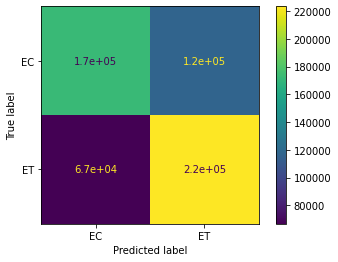

In [ ]:
%%time
cat_features = ['customer_legal_form', 'product_code']

parameters = {
    "n_estimators": [200, 250, 300],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2,3,4],
}

model_catboost = CatBoostClassifier(
    cat_features = cat_features,
    random_state=42,
    task_type="GPU",
    devices='0:1',
)

model_catboost = GridSearchCV(
    model_catboost, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_catboost.fit(x_train, y_train)

print(f'Best parameters {model_catboost.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_catboost.best_score_:.3f}'
)

y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))

cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()

del y_pred
gc.collect()

# cross_valid_scores['catboost'] = model_catboost.best_score_

              precision    recall  f1-score   support

          EC       0.71      0.70      0.70    290143
          ET       0.70      0.72      0.71    290143

    accuracy                           0.71    580286
   macro avg       0.71      0.71      0.71    580286
weighted avg       0.71      0.71      0.71    580286



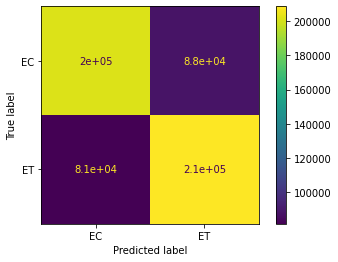

In [ ]:
cat_features = ['customer_legal_form', 'product_code']
model_catboost = CatBoostClassifier(
    n_estimators = 100,
    learning_rate = 0.01,
    max_depth = 2,
    task_type="GPU",
    devices='0:1',
).fit(x_train, y_train, cat_features,
      eval_set=(x_test, y_test),
             use_best_model=True,
             verbose=False)
y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))

cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()

In [ ]:
model_catboost.save_model("catboost")

XGBoost

In [33]:
enc = LabelEncoder()

x_train['customer_legal_form'] = enc.fit_transform(x_train['customer_legal_form'])
x_train['product_code'] = enc.fit_transform(x_train['product_code'])
x_test['customer_legal_form'] = enc.fit_transform(x_test['customer_legal_form'])
x_test['product_code'] = enc.fit_transform(x_test['product_code'])

In [15]:
x_train.head()

,customer_legal_form,price,product_code,time
0,41,116640.00,14345,87
1,25,356076.80,14004,8543
2,64,12116.75,13345,8763
3,28,63376.59,14028,7274
4,64,41537.22,13271,7427


Best parameters {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 250}
Mean cross-validated accuracy score of the best_estimator: 0.594
              precision    recall  f1-score   support

          EC       0.56      0.67      0.61    290143
          ET       0.58      0.47      0.52    290143

    accuracy                           0.57    580286
   macro avg       0.57      0.57      0.56    580286
weighted avg       0.57      0.57      0.56    580286

CPU times: user 8min 33s, sys: 6.17 s, total: 8min 39s
Wall time: 8min 38s


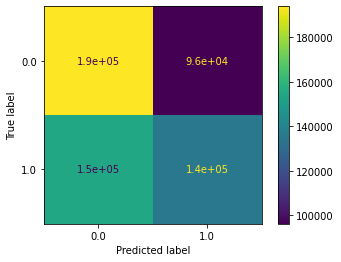

In [40]:
%%time
parameters = {
    "n_estimators": [200, 250, 300],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2,3,4],
}

model_xgb = xgb.XGBClassifier(
    random_state=42,
    tree_method='gpu_hist', 
    gpu_id=0,
)

model_xgb = GridSearchCV(
    model_xgb, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_xgb.fit(x_train, y_train.ravel())

print(f'Best parameters {model_xgb.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_xgb.best_score_:.3f}'
)

y_pred = model_xgb.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))

cm = confusion_matrix(y_test, y_pred, labels=model_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
disp.plot()

del y_pred
gc.collect()

# cross_valid_scores['xgboost'] = model_xgb.best_score_

In [ ]:
model_xgb.best_estimator_.save_model('XGBoost.json')

In [ ]:
pickle.dump(model_xgb.best_estimator_, open("XGBoost.pickle", "wb"))

Дерево решений

In [ ]:
parameters = {
    "max_depth": [3, 6, 9, 12],
}

model_desicion_tree = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
)

model_desicion_tree = GridSearchCV(
    model_desicion_tree, 
    parameters, 
    cv=5,
    scoring='accuracy'
)

model_desicion_tree.fit(x_train, y_train)

print(f'Best parameters {model_desicion_tree.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + \
    f'{model_desicion_tree.best_score_:.3f}'
)
cross_valid_scores['desicion_tree'] = model_desicion_tree.best_score_

              precision    recall  f1-score   support

          EC       0.85      0.81      0.83   1277451
          ET       0.20      0.25      0.23    245403

    accuracy                           0.72   1522854
   macro avg       0.53      0.53      0.53   1522854
weighted avg       0.75      0.72      0.73   1522854



3946

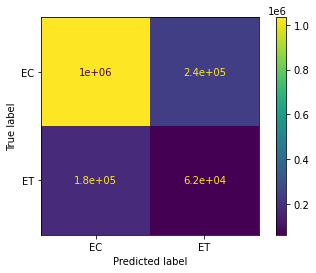

In [ ]:
y_pred = model_desicion_tree.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))

cm = confusion_matrix(y_test, y_pred, labels=model_desicion_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_desicion_tree.classes_)
disp.plot()

del y_pred
gc.collect()

Pipline with gridsearchcv for search the best estimator

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 102, in fit
    raise ValueError("learning_rate must be greater than zero")
ValueError: learning_rate must be greater than zero

  warnings.warn("Estimator fit failed. The score on 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 102, in fit
    raise ValueError("learning_rate must be greater than zero")
ValueError: learning_rate must be greater than zero

  warnings.warn("Estimator fit failed. The score on 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 847, in fit
    super(LGBMClassifier, self).fit(X, _y, sample_weight=sample_weight,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py", line 612, in fit
    self._Booster = train(params, train_set,
  File "C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py", line 231, in train
    booster = Booster(params=params, tr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly

Pipeline(steps=[('сlassifier',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=200,
                                    random_state=42))])
The mean accuracy of the model is: 0.8403931040007775
              precision    recall  f1-score   support

          EC       0.84      1.00      0.91   1277451
          ET       0.70      0.02      0.03    245403

    accuracy                           0.84   1522854
   macro avg       0.77      0.51      0.47   1522854
weighted avg       0.82      0.84      0.77   1522854



58

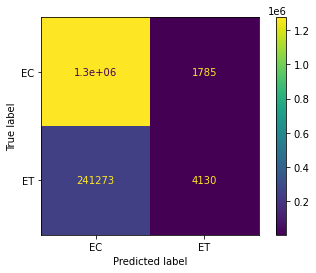

In [ ]:
model_desicion_tree = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'
)
model_random_forest = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
)
model_adaboost = AdaBoostClassifier(
    random_state=42,
)
model_lgbm = LGBMClassifier(
    random_state=42,
    class_weight='balanced',
)
logistic_model = LogisticRegression()
model_k_neighbors = KNeighborsClassifier()
pipe = Pipeline([('сlassifier', model_random_forest)])
parameters = [
    {'сlassifier': [model_random_forest],
     "сlassifier__max_depth": [3, 6, 9, 12], 
     },
    {'сlassifier': [model_desicion_tree],
     "сlassifier__max_depth": [3, 6, 9, 12], 
     },
    {'сlassifier': [model_adaboost], 
     "сlassifier__n_estimators": [10, 100, 200], 
     "сlassifier__learning_rate": [0.01, 0.1, 0.3],
     },
    {'сlassifier': [model_lgbm],
     "сlassifier__max_depth": [3, 6, 9, 12],
     "сlassifier__n_estimators": [10, 100, 200], 
     "сlassifier__learning_rate": [0.01, 0.1, 0.3],
     "сlassifier__num_leaves": [2, 4, 8, 16],
     },
    {'сlassifier': [logistic_model]},
    {'сlassifier': [model_k_neighbors],
     "сlassifier__weights": ["uniform", "distance"]
     }]
search = GridSearchCV(pipe, parameters, cv=5, scoring='accuracy')
best_model = search.fit(x_train, y_train)
 
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(x_test,y_test))
 
y_pred = best_model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))
 
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
 
del y_pred
gc.collect()

In [ ]:
pickle.dump(best_model.best_estimator_, open("BestModel.pickle", "wb"))

Случайный лес

In [ ]:
%%time
parameters = {
    "n_estimators": [10, 100, 200], 
    "max_depth": [3, 6, 9, 12],
}
 
model_random_forest = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
)
 
model_random_forest = GridSearchCV(
    model_random_forest, 
    parameters, 
    cv=5,
    scoring='accuracy',
)
 
model_random_forest.fit(x_train, y_train)
 
print(f'Best parameters {model_random_forest.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_random_forest.best_score_:.3f}'
)
cross_valid_scores['random_forest'] = model_random_forest.best_score_
 
print(classification_report(y_test, model_random_forest.predict(x_test), target_names=['EC', 'ET']))

Адаптивный бустинг

In [ ]:
%%time
parameters = {
    "n_estimators": [10, 100, 200], 
    "learning_rate": [0.01, 0.1, 0.3],
    "max_depth": [3, 6, 9, 12],
}

model_adaboost = AdaBoostClassifier(
    random_state=42,
)

model_adaboost = GridSearchCV(
    model_adaboost, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_adaboost.fit(x_train, y_train)

print(f'Best parameters {model_adaboost.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_adaboost.best_score_:.3f}'
)
cross_valid_scores['ada_boost'] = model_adaboost.best_score_

print(classification_report(y_test, model_adaboost.predict(x_test), target_names=['EC', 'ET']))

LightGBM

In [ ]:
%%time
parameters = {
    "n_estimators": [10, 100, 200], 
    "learning_rate": [0.01, 0.1, 0.3],
    "max_depth": [3, 6, 9, 12],
    'num_leaves': [2, 4, 8, 16],
}

model_lgbm = lgbm.LGBMClassifier(
    random_state=42,
    class_weight='balanced',
)

model_lgbm = GridSearchCV(
    model_lgbm, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_lgbm.fit(x_train, y_train, 
                eval_set=[(x_train, y_train,), (x_test, y_test,)], 
                eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200,
                categorical_feature=['customer_legal_form', 'price','product_code', 'time']
)

print(f'Best parameters {model_lgbm.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_lgbm.best_score_:.3f}'
)
cross_valid_scores['lightgbm'] = model_lgbm.best_score_

print(classification_report(y_test, model_lgbm.predict(x_test), target_names=['EC', 'ET']))

Логическая регрессия

              precision    recall  f1-score   support

          EC       0.60      0.56      0.58    290143
          ET       0.59      0.63      0.61    290143

    accuracy                           0.60    580286
   macro avg       0.60      0.60      0.60    580286
weighted avg       0.60      0.60      0.60    580286



4047

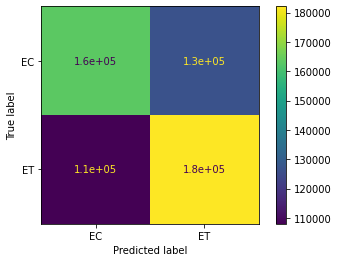

In [ ]:
logistic_model = LogisticRegression().fit(x_train, y_train.ravel())

y_pred = logistic_model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))
 
cm = confusion_matrix(y_test, y_pred, labels=logistic_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['EC', 'ET'])
disp.plot()

del y_pred
gc.collect()

In [ ]:
pickle.dump(logistic_model, open("logistic_model.pickle", "wb"))

K-средние

In [ ]:
%%time
parameters = {
    "weights": ["uniform", "distance"],
}

model_k_neighbors = KNeighborsClassifier()

model_k_neighbors = GridSearchCV(
    model_k_neighbors, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_k_neighbors.fit(preprocessing.scale(x_train), y_train)

print(f'Best parameters {model_k_neighbors.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_k_neighbors.best_score_:.3f}'
)
cross_valid_scores['k_neighbors'] = model_k_neighbors.best_score_

print(classification_report(y_test, model_k_neighbors.predict(preprocessing.scale(x_test)), target_names=['EC', 'ET']))

In [ ]:
pd.DataFrame(cross_valid_scores, index=['cross_valid_score']).T

#Для поставщиков

In [75]:
#Балансировка данных
data.sort_values('execution_period_start', inplace = True)
data.sort_values('current_contract_stage', inplace = True)
data = data.reset_index(drop=True)
data.drop(data[((data.index < 4712848) & (data['current_contract_stage']=="EC"))].index, inplace=True)
data.sort_values('execution_period_start', inplace = True)

gc.collect()

56

In [76]:
data_EC = data[data['current_contract_stage']=="EC"]
data_EC = data_EC.reset_index(drop=True)
data_ET = data[data['current_contract_stage']=="ET"]
data_ET = data_ET.reset_index(drop=True)

In [77]:
x_EC = data_EC.drop(['current_contract_stage', 'execution_period_start'], axis=1)
y_EC = data_EC['current_contract_stage']

x_ET = data_ET.drop(['current_contract_stage', 'execution_period_start'], axis=1)
y_ET = data_ET['current_contract_stage']

gc.collect()

0

In [78]:
x_train_EC, x_test_EC, y_train_EC, y_test_EC = train_test_split(x_EC, y_EC, test_size=0.2, shuffle = False)
x_train_ET, x_test_ET, y_train_ET, y_test_ET = train_test_split(x_ET, y_ET, test_size=0.2, shuffle = False)

In [79]:
x_train = pd.concat([x_train_EC, x_train_ET])
y_train = pd.concat([y_train_EC, y_train_ET])
x_test = pd.concat([x_test_EC, x_test_ET])
y_test = pd.concat([y_test_EC, y_test_ET])

In [80]:
print('EC', len(y_test[y_test == 'EC'].index))
print('ET', len(y_test[y_test == 'ET'].index))

EC 290143
ET 290143


In [81]:
print('EC', len(y_train[y_train == 'EC'].index))
print('ET', len(y_train[y_train == 'ET'].index))

EC 1160568
ET 1160568


In [82]:
del data_EC, data_ET, x_EC, x_ET, y_EC, y_ET, x_train_EC, x_test_EC, y_train_EC, y_test_EC, x_train_ET, x_test_ET, y_train_ET, y_test_ET
gc.collect()

351

Streaming output truncated to the last 5000 lines.
13:	learn: 0.6442980	total: 1.17s	remaining: 15.6s
14:	learn: 0.6417885	total: 1.25s	remaining: 15.5s
15:	learn: 0.6393662	total: 1.33s	remaining: 15.3s
16:	learn: 0.6370879	total: 1.41s	remaining: 15.2s
17:	learn: 0.6349065	total: 1.51s	remaining: 15.2s
18:	learn: 0.6327303	total: 1.59s	remaining: 15.1s
19:	learn: 0.6305545	total: 1.67s	remaining: 15s
20:	learn: 0.6285777	total: 1.75s	remaining: 14.9s
21:	learn: 0.6266529	total: 1.83s	remaining: 14.8s
22:	learn: 0.6247897	total: 1.91s	remaining: 14.7s
23:	learn: 0.6230047	total: 1.99s	remaining: 14.6s
24:	learn: 0.6211943	total: 2.07s	remaining: 14.5s
25:	learn: 0.6195555	total: 2.15s	remaining: 14.4s
26:	learn: 0.6179146	total: 2.23s	remaining: 14.3s
27:	learn: 0.6163056	total: 2.31s	remaining: 14.2s
28:	learn: 0.6147959	total: 2.39s	remaining: 14.1s
29:	learn: 0.6133278	total: 2.47s	remaining: 14s
30:	learn: 0.6119610	total: 2.56s	remaining: 13.9s
31:	learn: 0.6106078	total: 2.63s	r

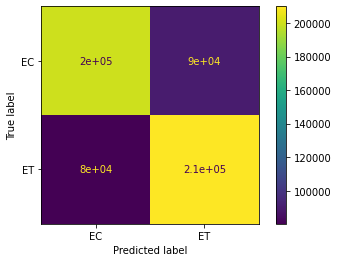

In [ ]:
%%time
cat_features = ['customer_legal_form', 'product_code', 'supplier_legal_form']

parameters = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.02, 0.03],
    "max_depth": [2,1],
}

model_catboost = CatBoostClassifier(
    cat_features = cat_features,
    random_state=42,
    task_type="GPU",
    devices='0:1',
)

model_catboost = GridSearchCV(
    model_catboost, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_catboost.fit(x_train, y_train)

print(f'Best parameters {model_catboost.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_catboost.best_score_:.3f}'
)

y_pred = model_catboost.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))

cm = confusion_matrix(y_test, y_pred, labels=model_catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_catboost.classes_)
disp.plot()

del y_pred
gc.collect()

In [ ]:
model_catboost.best_estimator_.save_model("/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/final/catboost(5input)")

In [83]:
enc = LabelEncoder()

x_train['customer_legal_form'] = enc.fit_transform(x_train['customer_legal_form'])
x_train['supplier_legal_form'] = enc.fit_transform(x_train['supplier_legal_form'])
x_train['product_code'] = enc.fit_transform(x_train['product_code'])
x_test['customer_legal_form'] = enc.fit_transform(x_test['customer_legal_form'])
x_test['supplier_legal_form'] = enc.fit_transform(x_test['supplier_legal_form'])
x_test['product_code'] = enc.fit_transform(x_test['product_code'])

Best parameters {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
Mean cross-validated accuracy score of the best_estimator: 0.599
              precision    recall  f1-score   support

          EC       0.56      0.73      0.64    290143
          ET       0.62      0.43      0.51    290143

    accuracy                           0.58    580286
   macro avg       0.59      0.58      0.57    580286
weighted avg       0.59      0.58      0.57    580286

CPU times: user 3min 51s, sys: 2.24 s, total: 3min 53s
Wall time: 3min 53s


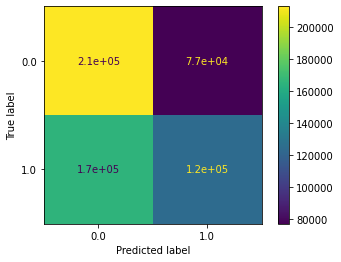

In [89]:
%%time
parameters = {
    "n_estimators": [300, 400, 500],
    "learning_rate": [0.05],
    "max_depth": [2,3,4],
}

model_xgb = xgb.XGBClassifier(
    random_state=42,
    tree_method='gpu_hist', 
    gpu_id=0,
)

model_xgb = GridSearchCV(
    model_xgb, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_xgb.fit(x_train, y_train.ravel())

print(f'Best parameters {model_xgb.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_xgb.best_score_:.3f}'
)

y_pred = model_xgb.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))

cm = confusion_matrix(y_test, y_pred, labels=model_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
disp.plot()

del y_pred
gc.collect()

Логическая

              precision    recall  f1-score   support

          EC       0.61      0.60      0.61    290143
          ET       0.61      0.61      0.61    290143

    accuracy                           0.61    580286
   macro avg       0.61      0.61      0.61    580286
weighted avg       0.61      0.61      0.61    580286



3640

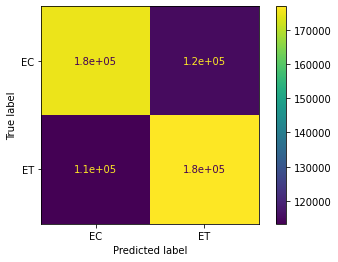

In [ ]:
logistic_model = LogisticRegression().fit(x_train, y_train.ravel())

y_pred = logistic_model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))
 
cm = confusion_matrix(y_test, y_pred, labels=logistic_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['EC', 'ET'])
disp.plot()

del y_pred
gc.collect()

# Нормализация и стандартизация данных

In [84]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

gc.collect()

220

In [85]:
x_train

array([[4.1000000e+01, 1.1664000e+05, 1.4345000e+04, 1.1000000e+01,
        8.7000000e+01],
       [2.5000000e+01, 3.5607680e+05, 1.4004000e+04, 1.3500000e+02,
        8.5430000e+03],
       [6.4000000e+01, 1.2116750e+04, 1.3345000e+04, 1.3500000e+02,
        8.7630000e+03],
       ...,
       [6.8000000e+01, 1.2273011e+05, 1.1950000e+03, 1.1000000e+01,
        3.4800000e+02],
       [6.9000000e+01, 5.7050000e+05, 1.3231000e+04, 9.0000000e+00,
        7.3000000e+01],
       [6.2000000e+01, 2.6118900e+05, 1.3000000e+03, 8.0000000e+00,
        3.4800000e+02]])

In [86]:
#стандартизация
x_train = preprocessing.scale(x_train)
x_test = preprocessing.scale(x_test)
#нормализация
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

In [87]:
def normalize_y(y):
  for i in range(len(y)):
      if y[i] == 'EC':
          y[i]= 1
      elif y[i] == 'ET':
          y[i]= 0
  return y
y_train = normalize_y(y_train)
y_test = normalize_y(y_test)

gc.collect()

0

In [88]:
x_train = np.asarray(x_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)

y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [39]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2321136, 4)
(2321136, 1)
(580286, 4)
(580286, 1)


Логическая регрессия

              precision    recall  f1-score   support

          EC       0.60      0.56      0.58    290143
          ET       0.59      0.63      0.61    290143

    accuracy                           0.60    580286
   macro avg       0.60      0.60      0.60    580286
weighted avg       0.60      0.60      0.60    580286



3886

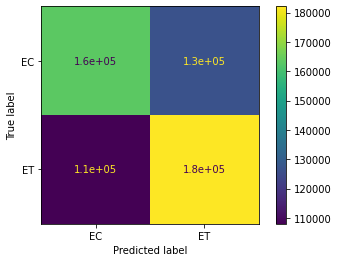

In [ ]:
logistic_model = LogisticRegression().fit(x_train, y_train.ravel())

y_pred = logistic_model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))
 
cm = confusion_matrix(y_test, y_pred, labels=logistic_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['EC', 'ET'])
disp.plot()

del y_pred
gc.collect()

# Создаем модель нейронной сети

In [ ]:
batch_size = 1000
epochs = 100
learning_rate = 0.01

loss = "binary_crossentropy"
optimizer = optimizers.Adam(lr = learning_rate)

In [ ]:
model = Sequential()
model.add(Dense(units = 20, activation = "sigmoid", input_dim=5, use_bias=False))
model.add(Dense(units = 20, activation = "sigmoid", use_bias=False))
model.add(Dense(units = 20, activation = "sigmoid", use_bias=False))
model.add(Dense(units = 1,  activation = "sigmoid"))

model.compile(loss = loss,
              optimizer = optimizer,
              metrics = ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                400       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 921
Trainable params: 921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [ ]:
history = model.fit(x_train,y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (x_test,y_test),
                    callbacks=None)

score = model.evaluate(x_test,y_test,verbose = 1)
print("test loss:",score[0])
print("test accuracy:",score[1])

Epoch 1/100
2322/2322 [==============================] - 9s 3ms/step - loss: 0.6527 - accuracy: 0.6137 - val_loss: 0.6544 - val_accuracy: 0.6361
Epoch 2/100
2322/2322 [==============================] - 6s 3ms/step - loss: 0.6133 - accuracy: 0.6642 - val_loss: 0.6455 - val_accuracy: 0.6365
Epoch 3/100
2322/2322 [==============================] - 6s 2ms/step - loss: 0.6057 - accuracy: 0.6708 - val_loss: 0.6637 - val_accuracy: 0.6282
Epoch 4/100
2322/2322 [==============================] - 6s 3ms/step - loss: 0.6002 - accuracy: 0.6767 - val_loss: 0.6795 - val_accuracy: 0.6151
Epoch 5/100
2322/2322 [==============================] - 6s 3ms/step - loss: 0.5974 - accuracy: 0.6790 - val_loss: 0.7010 - val_accuracy: 0.6114
Epoch 6/100
2322/2322 [==============================] - 6s 3ms/step - loss: 0.5962 - accuracy: 0.6800 - val_loss: 0.6981 - val_accuracy: 0.6166
Epoch 7/100
2322/2322 [==============================] - 6s 3ms/step - loss: 0.5940 - accuracy: 0.6821 - val_loss: 0.7059 - val_ac

              precision    recall  f1-score   support

          EC       0.61      0.52      0.56    290143
          ET       0.58      0.66      0.62    290143

    accuracy                           0.59    580286
   macro avg       0.59      0.59      0.59    580286
weighted avg       0.59      0.59      0.59    580286



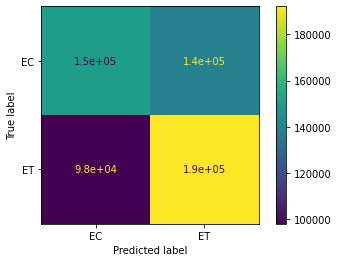

In [ ]:
y_pred = np.round(model.predict(x_test))
print(classification_report(y_test, y_pred, target_names=['EC', 'ET']))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['EC', 'ET'])
disp.plot()
del y_pred

In [ ]:
model.save('keras_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Модели-предсказатели завершенности тендеров/final/keras_model/assets


In [ ]:
model = keras.models.load_model("keras_model")

Text(0, 0.5, 'loss')

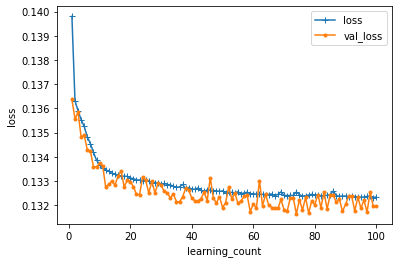

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

learning_count = len(loss)+1

plt.plot(range(1,learning_count),loss,marker = "+",label = "loss")
plt.plot(range(1,learning_count),val_loss,marker = ".",label = "val_loss")
plt.legend(loc = "best",fontsize = 10)
plt.xlabel("learning_count")
plt.ylabel("loss")

Text(0, 0.5, 'acc')

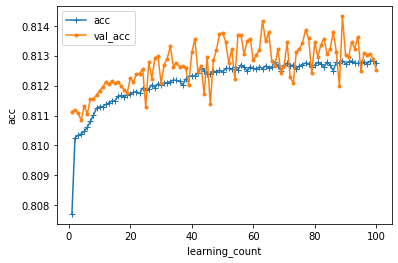

In [ ]:
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]

learning_count = len(loss)+1

plt.plot(range(1,learning_count),loss,marker = "+",label = "acc")
plt.plot(range(1,learning_count),val_loss,marker = ".",label = "val_acc")
plt.legend(loc = "best",fontsize = 10)
plt.xlabel("learning_count")
plt.ylabel("acc")

* R2: -4.84998826590099
* MAE: 0.26213125158419653
* MSE: 0.131635433780914
* RMSE: 0.3628159778467784

In [ ]:
del model
del history
gc.collect()

18265

#Линейная и полиномиальная
Сам код был удален по причине ненадобности, до этого писался ради проверки алгоритма, результат оправдал ожидания - такой себе, поэтому эта часть была удалена, но оставлены результаты проверки и сами модели
> Результаты линейной регрессии:
* R2: 4,3%
* MAE: 27,2%
* RMSE: 36,6%
* MSE: 13,4%

> Вот результаты полиномиальной регрессии 7й степени:
* R2: 10,5%
* MAE: 25,7%
* RMSE: 41,2%
* MSE: 16,9%

#Случайный лес


> * Score: 0.09982847643102365
* MAE: 0.27833340504976484
* MSE: 0.13874295754689808
* RMSE: 0.37248215735374235


> Значимость признака:
* [0.4095, 'time']
* [0.3735, 'product_code']
* [0.1172, 'supplier_legal_form']
* [0.0545, 'price']
* [0.0416, 'customer_legal_form']
* [0.0037, 'registration_period']





#XGBoost

In [ ]:
model = XGBClassifier(seed=42,
                      n_estimators=100,
                      max_depth=6,
                      learning_rate=0.3)
model.fit(x_train, y_train)
model.score(x_train, y_train)

[22:33:20] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


0.8174217620336552

In [ ]:
errors(model, x_test, y_test)

MAE: 0.18254803152501817
MSE: 0.18254803152501817
RMSE: 0.42725640021539546


После экспорта модели: 
* R2: -4.325824340536074
* MAE: 0.25816852354198105
* MSE: 0.12813976668150723
* RMSE: 0.35796615298308193

In [ ]:
y_pred_train = model.predict(x_train)
print (classification_report(y_train, y_pred_train))

y_pred = model.predict(x_test)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.13      0.22   1161095
         1.0       0.83      0.98      0.90   4930321

    accuracy                           0.82   6091416
   macro avg       0.71      0.56      0.56   6091416
weighted avg       0.78      0.82      0.77   6091416

              precision    recall  f1-score   support

         0.0       0.59      0.13      0.22    289616
         1.0       0.83      0.98      0.90   1233238

    accuracy                           0.82   1522854
   macro avg       0.71      0.56      0.56   1522854
weighted avg       0.78      0.82      0.77   1522854



In [ ]:
#значимость признаков для леса
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
col = ['customer_legal_form',	'price',	'product_code',	'supplier_legal_form',	'time']
ar_f=[]
for f, idx in enumerate(indices):
    ar_f.append([round(importances[idx],4), col[idx]])
print("Значимость признака:")
ar_f.sort(reverse=True)
ar_f

Значимость признака:


[[0.3291, 'time'],
 [0.2656, 'product_code'],
 [0.1533, 'supplier_legal_form'],
 [0.1265, 'customer_legal_form'],
 [0.1255, 'price']]

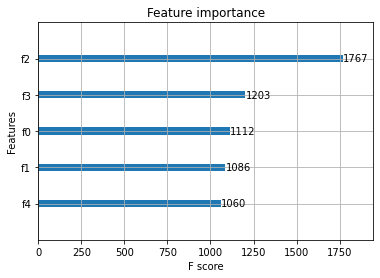

In [ ]:
import xgboost as xgb

xgb.plot_importance(model)

In [ ]:
#сохраним модель
model.save_model('XGBoost.json')

['XGBoost.pkl']

In [ ]:
del model
gc.collect()

310

# Ансамблирование алгоритмов

Идея ансамбля такая: берем выводы трех предыдущих моделей и используем их как x_train
Первые две модели тренируем на обычных выводах, две последние на выводах + x_train - своего рода адаптивный бустинг.

In [ ]:
nmodel = load_model("/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/5 input/val_loss(0,1316)val_acc(0,8131)input5.model") #нейронная сеть
lmodel = joblib.load('/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/5 input/logistic_model.pkl') #логическая регрессия
xmodel = xgb.Booster({'nthread': 4})
xmodel.load_model('/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/5 input/XGBoost.json') #случайный лес с градиентным бустингом (XGBoost)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
y_n = nmodel.predict(x_train)
y_l = lmodel.predict(x_train)
y_l = y_l.reshape(-1,1)
y_x = xmodel.predict(xgb.DMatrix(x_train))
y_x = y_x.reshape(-1,1)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
y_ensemble = np.concatenate((y_n, y_l, y_x), axis=1)
y_ensemble.shape

In [ ]:
result_model = XGBClassifier(seed=42,
                      n_estimators=100,
                      max_depth=6,
                      learning_rate=0.3)
result_model.fit(y_ensemble, y_train)
result_model.score(y_ensemble, y_train)

In [ ]:
y_n_test = nmodel.predict(x_test)
y_l_test = lmodel.predict(x_test)
y_l_test = y_l_test.reshape(-1,1)
y_x_test = xmodel.predict(xgb.DMatrix(x_test))
y_x_test = y_x_test.reshape(-1,1)
y_ensemble_test = np.concatenate((y_n_test, y_l_test, y_x_test), axis=1)

In [ ]:
errors(result_model, y_ensemble_test, y_test)

* R2: -3.868105259058125
* MAE: 0.25575278802170137
* MSE: 0.12796649005748417
* RMSE: 0.35772404176611355

In [ ]:
result_model.save_model('result_model1.json')

In [ ]:
del result_model
gc.collect()

In [ ]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
batch_size = 4000
epochs = 100
learning_rate = 0.01

loss = "mean_squared_error"
optimizer = optimizers.Adam(lr = learning_rate)

result_model2 = Sequential()
result_model2.add(Dense(units = 20, activation = "relu", input_dim=3, use_bias=True))
result_model2.add(Dense(units = 20, activation = "relu", use_bias=True))
result_model2.add(Dense(units = 1,  activation = "relu"))

result_model2.compile(loss = loss,
              optimizer = optimizer,
              metrics = ["accuracy"])

result_model2.summary()

checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history = result_model2.fit(y_ensemble,y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (y_ensemble_test, y_test),
                    callbacks=[checkpoint])

score = result_model2.evaluate(y_ensemble_test, y_test, verbose = 1)
print("test loss:",score[0])
print("test accuracy:",score[1])

In [ ]:
result_model2 = load_model("/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/5 input/ensemble/result_model2(loss_0.1281).model")

In [ ]:
errors(result_model2, y_ensemble_test, y_test)

* R2: -3.9380362283693673
* MAE: 0.2566147797162433
* MSE: 0.1280970528855688
* RMSE: 0.35790648623008886

In [ ]:
del result_model2
gc.collect()

In [ ]:
#Добавим адаптивности и протестим на двух моделях
y_ensemble = np.concatenate((x_train, y_n, y_l, y_x), axis=1)
y_ensemble.shape

In [ ]:
result_model3 = XGBClassifier(seed=42,
                      n_estimators=100,
                      max_depth=6,
                      learning_rate=0.3)
result_model3.fit(y_ensemble, y_train)
result_model3.score(y_ensemble, y_train)

* R2: -2.441480045377229
* MAE: 0.18081050448696986
* MSE: 0.18081050448696986
* RMSE: 0.4252181845676051
> после экспорта модели:
* R2: -3.7119245536355834
* MAE: 0.2538551996777104
* MSE: 0.12667766821376178
* RMSE: 0.3559180639048288

In [ ]:
y_ensemble_test = np.concatenate((x_test, y_n_test, y_l_test, y_x_test), axis=1)
errors(result_model3, y_ensemble_test, y_test)

In [ ]:
result_model3.save_model('result_model3.json')

In [ ]:
del result_model3
gc.collect()

In [ ]:
batch_size = 4000
epochs = 100
learning_rate = 0.01

loss = "mean_squared_error"
optimizer = optimizers.Adam(lr = learning_rate)

result_model4 = Sequential()
result_model4.add(Dense(units = 20, activation = "relu", input_dim=8, use_bias=True))
result_model4.add(Dense(units = 20, activation = "relu", use_bias=True))
result_model4.add(Dense(units = 1,  activation = "relu"))

result_model4.compile(loss = loss,
              optimizer = optimizer,
              metrics = ["accuracy"])

result_model4.summary()

checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history = result_model4.fit(y_ensemble,y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    validation_data = (y_ensemble_test, y_test),
                    callbacks=[checkpoint])

score = result_model4.evaluate(y_ensemble_test,y_test,verbose = 1)
print("test loss:",score[0])
print("test accuracy:",score[1])

In [ ]:
result_model4 = load_model("/content/drive/MyDrive/Модели-предсказатели завершенности тендеров/5 input/ensemble/result_model4(loss_0.1280).model")

In [ ]:
errors(result_model2, y_ensemble_test, y_test)

* R2: -3.8962974941958723
* MAE: 0.25669392797996393
* MSE: 0.12802687215911704
* RMSE: 0.3578084294131666

In [ ]:
del result_model4
gc.collect()

#Анализ периода от начала регистрации до старта исполнения

Почему здесь, а не в ноутбуке, где находится весь анализ? Там переполняется RAM, надо смотреть где можно оптимизировать, а пока этот код полежит здесь.

Гипотеза: есть предположение, что выбросы в этом признаке могут портить модель, так как после добавления этого признака качество модели упало.

In [ ]:
data.corr()

,index,id,price,time,registration_period
index,1.000000,-0.997645,-0.013175,-0.009461,-0.048884
id,-0.997645,1.000000,0.013289,0.004592,0.048542
price,-0.013175,0.013289,1.000000,0.045198,0.003255
time,-0.009461,0.004592,0.045198,1.000000,0.081238
registration_period,-0.048884,0.048542,0.003255,0.081238,1.000000


84

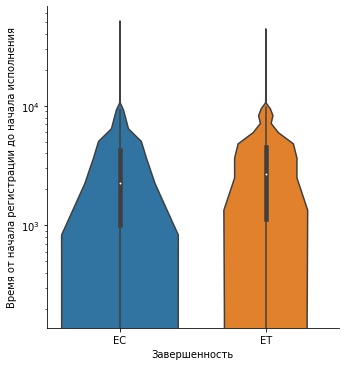

In [ ]:
g = sbs.catplot(x = 'current_contract_stage', y = 'registration_period', kind ='violin', aspect = 1, data = data)
g.set(yscale = 'log', xlabel = 'Завершенность', ylabel = 'Время от начала регистрации до начала исполнения')

del g
gc.collect()

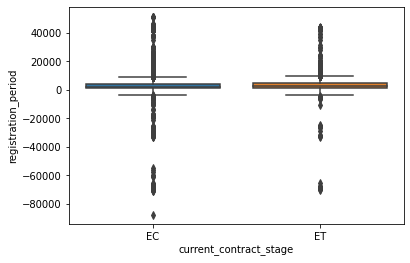

In [ ]:
sbs.boxplot(x='current_contract_stage', y='registration_period', data=data)
plt.show()

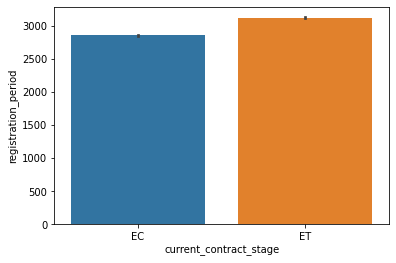

In [ ]:
sbs.barplot(x='current_contract_stage', y='registration_period', data=data);

Вывод: Можно заметить, что средние значения регистрационного периода довольно высокие, а в "исполнение прекращено" средняя задержка немного больше, но не значительно, однако если взглянуть в boxplot, можно увидеть, что основная часть контрактов не имела большого регистрационного периода, соответственно, большие среднии появляются благодаря выбросам, что в конечном итоге будет мешать строить предсказательные модели, соответственно, в срочном порядке стоит удалить этот признак из датасета.